# LiberTEM UDFs

In [1]:
%matplotlib nbagg

In [2]:
import os
import matplotlib.pyplot as plt
import libertem.api as lt
import numpy as np

In [3]:
ctx = lt.Context()

## Specifying the dataset

Most formats can be loaded using the `"auto"` type, but some may need additional parameters.

See the [loading data](https://libertem.github.io/LiberTEM/formats.html) section of the LiberTEM docs for details.

In [4]:
data_base_path = os.environ.get("TESTDATA_BASE_PATH", "/home/alex/Data/")

In [5]:
ds = ctx.load("auto", path=os.path.join(data_base_path, "01_ms1_3p3gK.hdr"))

After loading, some information is available in the `diagnostics` attribute:

In [6]:
ds.diagnostics

[{'name': 'Bits per pixel', 'value': '12'},
 {'name': 'Data kind', 'value': 'u'},
 {'name': 'Layout', 'value': '(1, 1)'},
 {'name': 'Partition shape', 'value': '(2075, 256, 256)'},
 {'name': 'Number of partitions', 'value': '33'},
 {'name': 'Number of frames skipped at the beginning', 'value': 0},
 {'name': 'Number of frames ignored at the end', 'value': 0},
 {'name': 'Number of blank frames inserted at the beginning', 'value': 0},
 {'name': 'Number of blank frames inserted at the end', 'value': 0}]

## Standard analyses: virtual detector

A standard analysis to run on 4D STEM data is to apply a virtual detector. Here, we define a ring detector, with radii in pixels:

In [7]:
ring = ctx.create_ring_analysis(dataset=ds, ri=60, ro=70)

The analysis can be run with the `Context.run` method:

In [8]:
ring_res = ctx.run(ring, progress=True)
ring_res

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:08<00:00,  4.00it/s]


[<AnalysisResult: intensity>, <AnalysisResult: intensity_log>]

As the analysis mirrors what the web GUI does, we have to access the data using the `raw_data` attribute, as we would get a viusalized result otherwise. Here we do the visualization ourselves using `matplotlib`:

<IPython.core.display.Javascript object>


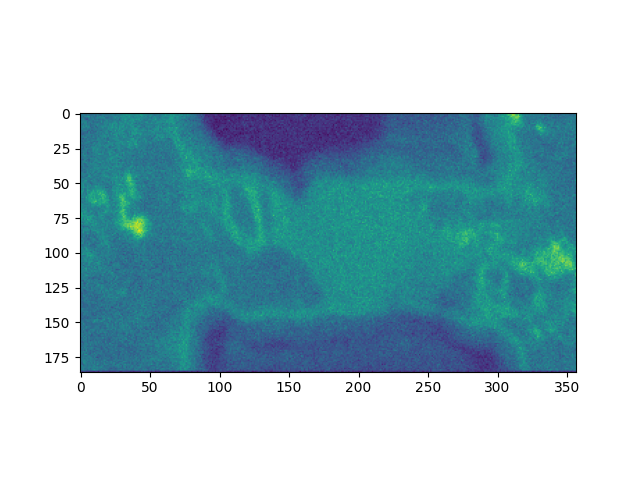

In [9]:
plt.figure()
plt.imshow(ring_res.intensity.raw_data)

## Simple UDF definition

User-defined funtions provide a way for you to implement your own data processing functionality. As a very simple example, we define a function that just sums up the pixels of each frame:

In [10]:
def sum_of_pixels(frame):
    return np.sum(frame)

The easiest way to run this on the data is to use the `Context.map` function:

In [11]:
res_pixelsum_1 = ctx.map(dataset=ds, f=sum_of_pixels, progress=True)
res_pixelsum_1

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:08<00:00,  3.86it/s]


<BufferWrapper kind=nav dtype=float32 extra_shape=()>

The result is of type `BufferWrapper`, but can be used by any function that expects a numpy array, for example for plotting it:

<IPython.core.display.Javascript object>


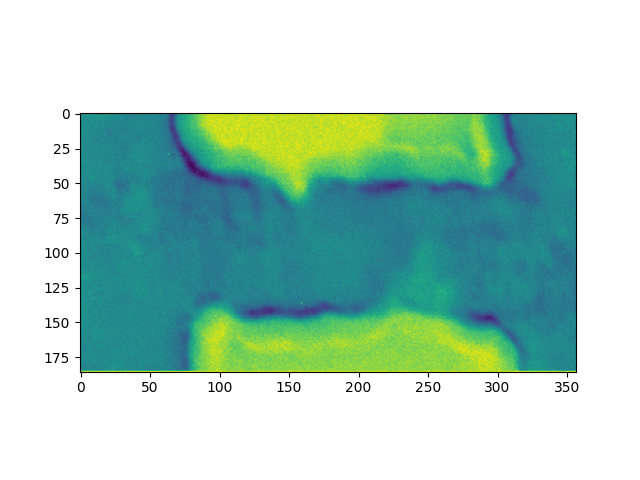

In [12]:
plt.figure()
plt.imshow(res_pixelsum_1)

The `Context.map` function is a shortcut for implementing very easy mapping over data, in a frame-by-frame fashion. The longer way of writing this would be as follows:

In [13]:
from libertem.udf import UDF


class SumOfPixels(UDF):
    def get_result_buffers(self):
        return {
            'sum_of_pixels': self.buffer(kind='nav', dtype='float32')
        }
    
    def process_frame(self, frame):
        self.results.sum_of_pixels[:] = np.sum(frame)

This can now be run using the `Context.run_udf` method:

In [14]:
res_pixelsum_2 = ctx.run_udf(dataset=ds, udf=SumOfPixels(), progress=True)
res_pixelsum_2

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:09<00:00,  3.43it/s]


{'sum_of_pixels': <BufferWrapper kind=nav dtype=float32 extra_shape=()>}

The result is now a `dict`, which maps buffer names, as defined in `get_result_buffers`, to the `BufferWrapper` result, so we can use the following to plot the results:

<IPython.core.display.Javascript object>


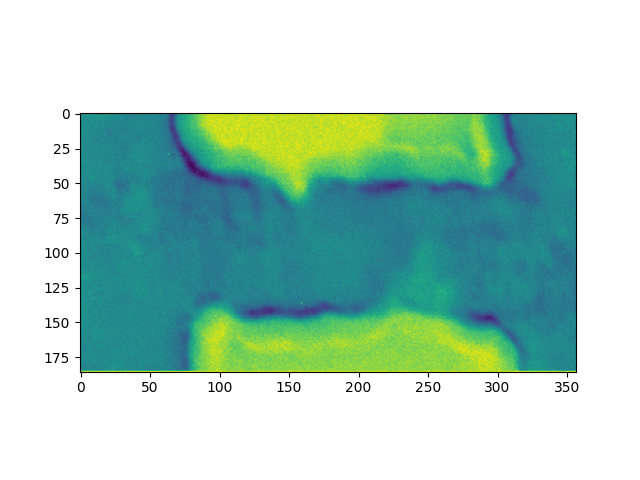

In [15]:
plt.figure()
plt.imshow(res_pixelsum_2['sum_of_pixels'])

## `extra_shape`: more than one result per scan position

In [16]:
class StatsUDF(UDF):
    def get_result_buffers(self):
        return {
            'all_stats': self.buffer(kind='nav', dtype='float32', extra_shape=(4,)),
        }
    
    def process_frame(self, frame):
        self.results.all_stats[:] = (np.mean(frame), np.min(frame), np.max(frame), np.std(frame))

In [17]:
res_stats = ctx.run_udf(dataset=ds, udf=StatsUDF(), progress=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:15<00:00,  2.13it/s]


Result now has an extra dimension, as specified by `extra_shape` above:

In [18]:
res_stats['all_stats'].data.shape

(186, 357, 4)

Let's plot the `stddev` of each frame:

<IPython.core.display.Javascript object>


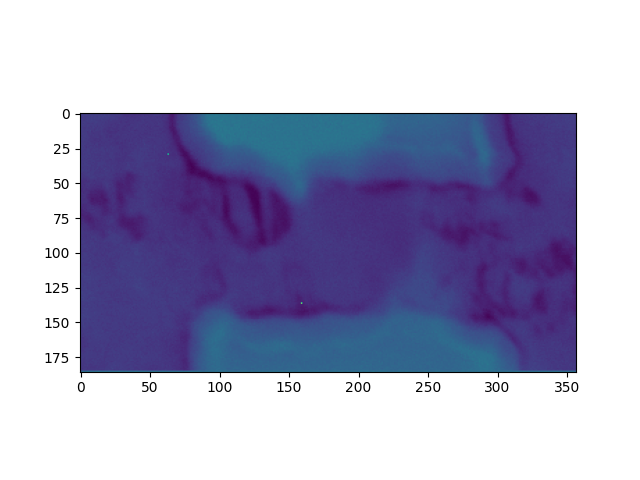

In [19]:
plt.figure()
plt.imshow(res_stats['all_stats'].data[..., 3])

## kind="sig" buffers, merge functions
- Previously: one result for each scan position
- Now: result buffer shaped like the diffraction patterns
- We need a merge function to merge the result of one partition into the final result
- Different buffer kinds can be combined in a single UDF, so you can combine different operations in a single pass over the data

In [20]:
class MaxFrameUDF(UDF):
    def get_result_buffers(self):
        return {
            'maxframe': self.buffer(kind='sig', dtype='float32')
        }
    
    def process_frame(self, frame):
        # element-wise maximum:
        self.results.maxframe[:] = np.maximum(self.results.maxframe, frame)

    def merge(self, dest, src):
        # src: the maximum observed in the current partition
        # dest: the maximum observed in all partitions that were already merged together
        dest.maxframe[:] = np.maximum(dest.maxframe, src.maxframe)

In [21]:
res_max = ctx.run_udf(dataset=ds, udf=MaxFrameUDF(), progress=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.96it/s]


<IPython.core.display.Javascript object>


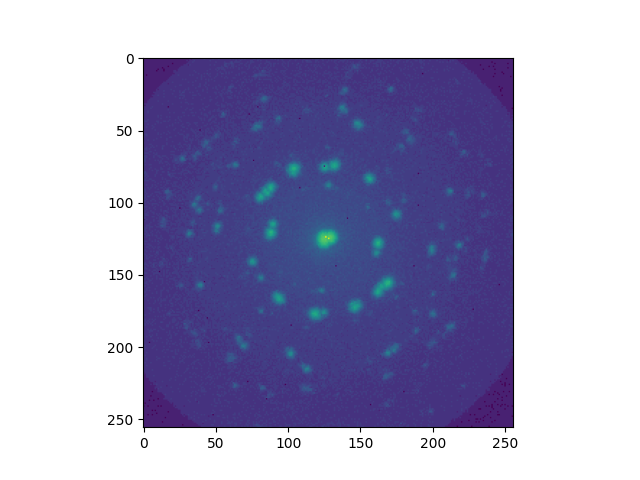

In [22]:
plt.figure()
plt.imshow(np.log1p(res_max['maxframe']))

## Region of interest

- work on a subset of the navigation axes
- can be used with all UDFs
- useful for working selectively on data, or just reducing the I/O and computational load when implementing a new UDF
- defined as a binary mask

Let's create a mask based on the previously calculated pixel-sum:

In [23]:
from skimage.morphology import opening, closing

In [24]:
np.min(res_pixelsum_1),  np.max(res_pixelsum_1), np.mean(res_pixelsum_1)

(7762.0, 12367.0, 10277.385)

<IPython.core.display.Javascript object>


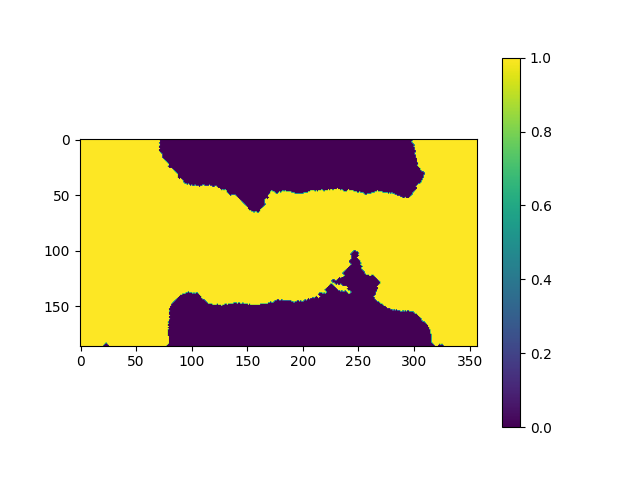

In [25]:
mask = res_pixelsum_1.data < np.mean(res_pixelsum_1)
# mask = opening(mask)
mask = closing(opening(mask))

plt.figure()
plt.imshow(mask.astype("float32"))
plt.colorbar()

In [26]:
res_roi = ctx.run_udf(dataset=ds, udf=StatsUDF(), roi=mask, progress=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:10<00:00,  3.13it/s]


<IPython.core.display.Javascript object>


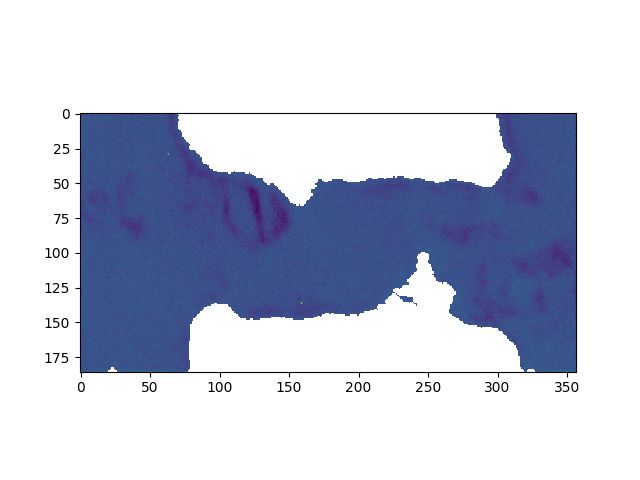

In [27]:
plt.figure()
plt.imshow(np.log1p(res_roi['all_stats'].data[..., 2]))

### Results with ROI applied

One has to take some care when handling results where a `roi` was applied; just using the result as a numpy array or accessing the `data` attribute will give you a result that keeps the whole dataset shape, where the deselected parts are filled with `NaN` values:

In [28]:
res_roi['all_stats'].data.shape

(186, 357, 4)

There is a second attribute, `raw_data`, which will give you a flattenned array of just the results, like numpy would give you for fancy indexing:

In [29]:
res_roi['all_stats'].raw_data.shape

(45358, 4)

## Parameters

Keyword arguments passed to the UDF are made available in `self.params` on the UDF. A good convention to document your parameters is to put a docstring into your `__init__` method and just pass on the values to `super().__init__`. You can also validate the arguments here.

In [30]:
class PixelPicker(UDF):
    def __init__(self, coords, *args, **kwargs):
        """
        Parameters
        ----------
        coords : Tuple[int]
            The coordinates to look at in each frame
        """
        if len(coords) != 2:
            raise ValueError("invalid coordinates")
        super().__init__(*args, coords=coords, **kwargs)
        
    def get_result_buffers(self):
        return {
            'value_of_pixel': self.buffer(kind='nav', dtype=np.float32)
        }
    
    def process_frame(self, frame):
        self.results.value_of_pixel[:] = frame[self.params.coords]

In [31]:
res_pixel_picker = ctx.run_udf(dataset=ds, udf=PixelPicker(coords=(128, 128)), progress=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:06<00:00,  5.23it/s]


<IPython.core.display.Javascript object>


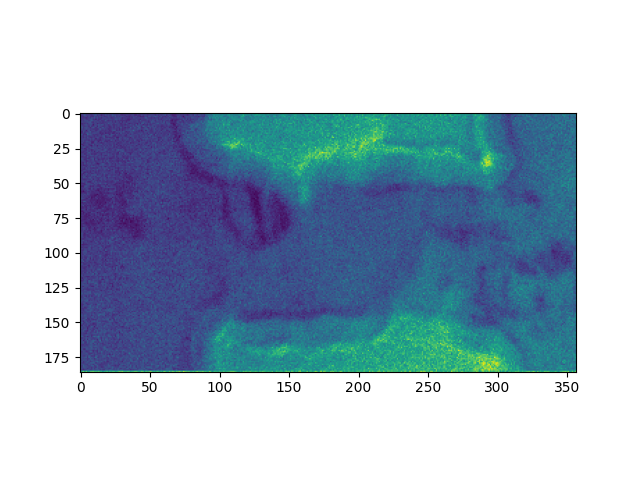

In [32]:
plt.figure()
plt.imshow(res_pixel_picker['value_of_pixel'])